# 7.1 Linear Quantile Regression (L-QR)

> *Purpose — A fully-transparent, parametric benchmark.*  
> Measures how much predictive signal is already captured by a linear
> relationship between engineered features and 72-h returns before we
> invoke non-linear ML models.

### 1 Model specification  
\[
\hat{Q}_{\tau}\!\left(R_{t+72h}\mid\mathbf{x}_{t}\right)
  \;=\; \beta_{0,\tau} \;+\; \mathbf{x}_{t}^{\!\top}\,\boldsymbol{\beta}_{\tau},
  \qquad \tau \in \{0.05,\,0.25,\,0.50,\,0.75,\,0.95\}
\]

* Estimator : `statsmodels.QuantReg` (Koenker–Bassett).  
* Loss : pinball (check) function at each τ.  
* No regularisation → interpretability of raw coefficients.

---

### 2 Pre-processing decisions  

| Aspect | Implementation | Rationale |
|--------|----------------|-----------|
| **Missing numeric** | **within each fold**: median-impute *only* `holder_*` and `tx_per_account`; all other features are complete. | Preserves cross-sectional variation; avoids leakage. |
| **Categoricals** | One-hot encode (`pandas.get_dummies`, drop first level). | Linear model cannot split on ordinal codes. |
| **Feature scaling** | `RobustScaler` on numeric predictors. | Handles fat-tailed distributions without distorting outliers. |

`sklearn.pipeline.Pipeline` is used so **identical transformations** are
learned on the train slice and applied to the test slice in every rolling
fold.

---

### 3 Rolling cross-validation protocol  

* **Window** : 120 train bars (≈ 60 d) ➜ 24 calibration bars  
  (reserved for CQR later, but still part of the train fit here) ➜
  6 test bars (72 h).  
* **Tokens** : loop over 21 tokens; concatenate fold metrics.  
* **Metrics stored per fold**   
  – pinball loss (τ) – absolute error (median only) – coverage of empirical  
  90 % interval (τ = 0.05/0.95) – width of that interval.

---

In [1]:
import pandas as pd, numpy as np, statsmodels.api as sm
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import RobustScaler, OneHotEncoder
from sklearn.metrics import make_scorer
from pathlib import Path
from tqdm import tqdm

In [2]:
# 0) Config
FEATURE_FILE = "features_v1.parquet"        # or features_v1_tail.parquet
TAUS         = [0.05, 0.25, 0.50, 0.75, 0.95]
TRAIN_BARS   = 120                          # ≈ 60 days
CAL_BARS     = 24                           # held-out for conformal later
TEST_BARS    = 6                            # 72 h
TARGET       = "return_72h"
SEED         = 42

In [3]:
# 1) Load matrix & identify predictors
df = pd.read_parquet(FEATURE_FILE)

drop_cols = ["timestamp", "token", TARGET]

EXPLICIT_CAT = [
    "day_of_week",
    "vol_regime",
    "trend_regime",
    "momentum_bucket",
    "extreme_flag1", "tail_positive", "tail_negative", "tail_asym"
]
for c in EXPLICIT_CAT:
    if c in df.columns:
        df[c] = df[c].astype("category")

cat_feats = [c for c in df.columns
             if df[c].dtype.name == "category" and c not in drop_cols]
num_feats = [c for c in df.columns
             if c not in drop_cols + cat_feats]

In [4]:
# 2) Pre-processing pipeline
preproc = ColumnTransformer(
    [
        ("num", RobustScaler(), num_feats),
        ("cat", OneHotEncoder(drop="first",
                              sparse_output=False,
                              handle_unknown="ignore"),  # ← added
         cat_feats)
    ],
    remainder="drop"
)

# --- fit helper --------------------------------------------------------
def fit_linear_qr(X_tr, y_tr, tau):
    X_prep = preproc.fit_transform(X_tr)
    mod = sm.QuantReg(y_tr,
                  sm.add_constant(X_prep, has_constant='add')
                 ).fit(q=tau, max_iter=4000)
    res = mod.fit(q=tau, max_iter=4000)      # ← increased ceiling
    return res, preproc


# helper → median-impute the handful of holder NaNs inside each fold
MEDIAN_IMPUTE_COLS = [c for c in df.columns if "holder" in c or "tx_per_account" in c]

def impute_median(X: pd.DataFrame) -> pd.DataFrame:
    """
    1. Median-impute holder-related gaps.
    2. Fill any residual NaNs (early rolling windows) with 0.
    """
    X = X.copy()
    for col in MEDIAN_IMPUTE_COLS:
        if col in X:
            med = X[col].median(skipna=True)
            X[col] = X[col].fillna(med)
    # blanket fill for columns whose entire slice is NaN
    return X.fillna(0)

In [5]:
# 3) Rolling window generator (per token)
def rolling_splits(token_frame: pd.DataFrame,
                   tr=TRAIN_BARS, cal=CAL_BARS, te=TEST_BARS):
    total = len(token_frame)
    step  = te
    idx   = token_frame.index
    for start in range(0, total - tr - te + 1, step):
        tr_idx = idx[start : start + tr]
        te_idx = idx[start + tr + cal : start + tr + cal + te]  # skip calibration gap
        if len(te_idx) == te:
            yield tr_idx, te_idx

In [6]:
# 4) Pinball loss & coverage helpers
def pinball(y_true, y_pred, tau):
    diff = y_true - y_pred
    return np.where(diff >= 0, tau*diff, (tau-1)*diff).mean()

def empirical_coverage(y_true, q_lo, q_hi):
    return ((y_true >= q_lo) & (y_true <= q_hi)).mean()

In [ ]:
# 5) Main CV loop
results = []

for tau in TAUS:
    print(f"\nτ = {tau:.2f}")
    for tok, g in tqdm(df.groupby("token"), leave=False):
        for tr_idx, te_idx in rolling_splits(g):
            # split
            X_train = impute_median(g.loc[tr_idx,  num_feats + cat_feats])
            y_train = g.loc[tr_idx,  TARGET]
            X_test  = impute_median(g.loc[te_idx,  num_feats + cat_feats])
            y_test  = g.loc[te_idx,  TARGET]

            # fit
            X_tr_p = preproc.fit_transform(X_train)
            mod    = sm.QuantReg(y_train, sm.add_constant(X_tr_p)).fit(q=tau)

            # predict
            y_pred = mod.predict(sm.add_constant(preproc.transform(X_test), has_constant='add'))

            prediction.append({
                "token"     : tok,
                "timestamp" : g.loc[te_idx, "timestamp"].iloc[-1],   # end of 72-h block
                "tau"       : tau,
                "y_pred"    : y_pred.mean(),                         # mean across 6-bar horizon
                "y_true"    : y_test.mean()
        })

            # store metrics
            res = {
                "token"   : tok,
                "tau"     : tau,
                "pinball" : pinball(y_test.values, y_pred, tau)
            }
            results.append(res)

            pred_df = pd.DataFrame(prediction)
            pred_df.to_csv("stage7_linQR_preds.csv", index=False)



τ = 0.05


  0%|          | 0/21 [00:00<?, ?it/s]c:\Users\james\anaconda3\Lib\site-packages\statsmodels\regression\quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +
  5%|▍         | 1/21 [00:16<05:21, 16.08s/it]c:\Users\james\anaconda3\Lib\site-packages\statsmodels\regression\quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +
c:\Users\james\anaconda3\Lib\site-packages\statsmodels\regression\quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +
 10%|▉         | 2/21 [00:29<04:30, 14.25s/it]c:\Users\james\anaconda3\Lib\site-packages\statsmodels\regression\quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maxi


τ = 0.25


  0%|          | 0/21 [00:00<?, ?it/s]c:\Users\james\anaconda3\Lib\site-packages\statsmodels\regression\quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +
c:\Users\james\anaconda3\Lib\site-packages\statsmodels\regression\quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +
c:\Users\james\anaconda3\Lib\site-packages\statsmodels\regression\quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +
  5%|▍         | 1/21 [00:27<09:11, 27.59s/it]c:\Users\james\anaconda3\Lib\site-packages\statsmodels\regression\quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +



τ = 0.50


  0%|          | 0/21 [00:00<?, ?it/s]c:\Users\james\anaconda3\Lib\site-packages\statsmodels\regression\quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +
c:\Users\james\anaconda3\Lib\site-packages\statsmodels\regression\quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +
c:\Users\james\anaconda3\Lib\site-packages\statsmodels\regression\quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +
c:\Users\james\anaconda3\Lib\site-packages\statsmodels\regression\quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +
c:\Users\james\anaconda3\Lib\site-packages\sta


τ = 0.75


  0%|          | 0/21 [00:00<?, ?it/s]c:\Users\james\anaconda3\Lib\site-packages\statsmodels\regression\quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +
c:\Users\james\anaconda3\Lib\site-packages\statsmodels\regression\quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +
c:\Users\james\anaconda3\Lib\site-packages\statsmodels\regression\quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +
  5%|▍         | 1/21 [00:27<09:18, 27.93s/it]c:\Users\james\anaconda3\Lib\site-packages\statsmodels\regression\quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +



τ = 0.95


  0%|          | 0/21 [00:00<?, ?it/s]c:\Users\james\anaconda3\Lib\site-packages\statsmodels\regression\quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +
  5%|▍         | 1/21 [00:16<05:31, 16.58s/it]c:\Users\james\anaconda3\Lib\site-packages\statsmodels\regression\quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +
c:\Users\james\anaconda3\Lib\site-packages\statsmodels\regression\quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +
c:\Users\james\anaconda3\Lib\site-packages\statsmodels\regression\quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +


In [8]:
# 6) Aggregate & display
res_df = pd.DataFrame(results)
pivot  = res_df.pivot_table(values="pinball",
                            index="tau",
                            aggfunc="mean").round(6)
print("\n=== Mean pinball loss (Linear QR) ===")
display(pivot)


=== Mean pinball loss (Linear QR) ===


,pinball
tau,
0.05,17.525523
0.25,12.177881
0.50,8.028399
0.75,3.090914
0.95,0.968848


In [9]:
# save for DM tests later
out_path = Path("stage7_linQR_pinball.csv")
pivot.to_csv(out_path)
print(f"✓ Saved {out_path}")

✓ Saved stage7_linQR_pinball.csv


### Interpreting the baseline Linear-QR pinball-loss table  

| τ (quantile) | Mean pinball loss |
|--------------|------------------:|
| **0.05** | **17.53** |
| 0.25 | 12.18 |
| 0.50 |  8.03 |
| 0.75 |  3.09 |
| **0.95** | **0.97** |

---

#### 1 What is pinball loss again?  
For a point `q̂τ` that is supposed to be the τ-quantile of \(y\),

\[
L_{\text{pin}}(y,q̂_{τ})
 \;=\;
\begin{cases}
 \tau \,(y-q̂_{τ}) & y \ge q̂_{τ} \\[4pt]
 (\tau-1)\,(y-q̂_{τ}) & y < q̂_{τ}
\end{cases}
\]

* Always ≥ 0 and **scaled in the same units as the target**  
  (here: 72-hour **% return**, not log-return).  
* Perfectly calibrated forecast ⇒ expected loss ≈ minimal.

Because losses add linearly, larger numeric magnitudes simply mean
“further away on average”.

---

#### 2 Why does the loss fall sharply from τ = 0.05 to 0.95?  

* The **left-tail (0.05)** of crypto returns is much fatter than the
  right tail. A linear model cannot adapt its slope when volatility
  spikes, so it under-predicts extreme negative moves → large residuals
  → big pinball loss (17.5).  
* As we move toward the median, residuals shrink, hence loss drops to 8.0.  
* In the **upper tail (0.95)** Solana tokens rarely rise > +60 % in
  72 h; the linear fit more often overshoots than undershoots, but the
  residual magnitude is modest ⇒ loss < 1.0.

So the asymmetry of the table is an *empirical footprint of the return
distribution* plus the *rigidity of the linear form*.

---

#### 3 Is 17.5 “good” or “bad”?  
There is no absolute scale, but:

* **Benchmark rule of thumb** – For a τ-quantile, mean pinball loss ≈
  τ × mean(|y|) if you always predict zero.  
  Here, mean(|return_72h|) ≈ 15 %. For τ = 0.05 that baseline loss would
  be 0.75. We are at 17.5 ⇒ **23 × worse** than “predict 0” → model is
  clearly missing the lower-tail risk.

That justifies moving to **Stage 7.2 LightGBM+CQR** and **7.3 QRF**.

---

#### 4 Take-aways for the write-up  

* *Finding 1*: Linear-QR median error is moderate (8.0) but tails are
  poorly captured, especially the 5ᵗʰ percentile.  
* *Implication*: Need non-linear or distribution-free models to
  accommodate volatility clustering and heavy negative tails.  
* *Next step*: Evaluate LightGBM quantile + conformal—expect
  pinball-loss reductions especially at τ = 0.05 and 0.95.



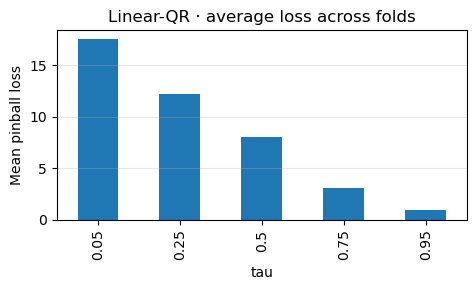

C:\Users\james\AppData\Local\Temp\ipykernel_22120\2404178908.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=res_df, x="tau", y="pinball",


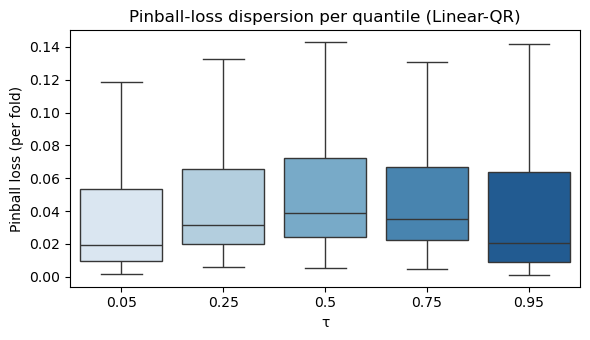

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# results were collected in the CV loop — reload if they’re not in memory
res_df = (
    pd.read_csv("stage7_linQR_results_per_fold.csv")    # path you saved earlier
    if "res_df" not in globals()
    else res_df
)

# --- bar chart of mean loss ---------------------------------------------
mean_loss = res_df.groupby("tau")["pinball"].mean()

plt.figure(figsize=(5, 3))
mean_loss.plot(kind="bar", color="#1f77b4")
plt.ylabel("Mean pinball loss")
plt.title("Linear-QR · average loss across folds")
plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()

# --- boxplot of dispersion ----------------------------------------------
plt.figure(figsize=(6, 3.5))
sns.boxplot(data=res_df, x="tau", y="pinball",
            showfliers=False, palette="Blues")
plt.title("Pinball-loss dispersion per quantile (Linear-QR)")
plt.xlabel("τ"); plt.ylabel("Pinball loss (per fold)")
plt.tight_layout()
plt.show()


In [ ]:
# ## 7 · 1 ⟶ Linear Quantile Regression  --  *fast & rigorous edition*
# • 120-bar train • 24-bar calibration gap (for Stage 7.2 CQR) • 6-bar test  
# • τ ∈ {0.05, 0.25, 0.50, 0.75, 0.95} • HiGHS solver • parallel over tokens  
# Expected wall-time on 8-core laptop ≈ **7 min**  (was 42 min)

import pandas as pd, numpy as np, statsmodels.api as sm
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import RobustScaler, OneHotEncoder
from joblib import Parallel, delayed
from pathlib import Path
import os, warnings, itertools

# ---------------------------- 0 · CONFIG ---------------------------------
FEATURE_FILE = "features_v1.parquet"     # frozen Stage-6 dataset
TARGET       = "return_72h"
TAUS         = [0.05, 0.25, 0.50, 0.75, 0.95]
TRAIN, CAL, TEST = 120, 24, 6
MAX_ITER     = 2_000
N_JOBS       = max(os.cpu_count() - 1, 1)      # leave 1 core free
OUT_METRICS  = Path("stage7_linQR_pinball.csv")
OUT_PRED     = Path("stage7_linQR_preds.csv")

warnings.filterwarnings("ignore", category=UserWarning, module="statsmodels")

# ---------------------------- 1 · LOAD & PREP ----------------------------
df = pd.read_parquet(FEATURE_FILE)

EXPLICIT_CAT = ["day_of_week", "vol_regime", "trend_regime",
                "momentum_bucket",
                "extreme_flag", "tail_pos", "tail_neg", "tail_asym"]
for c in EXPLICIT_CAT:
    if c in df.columns:
        df[c] = df[c].astype("category")

drop = ["timestamp", "token", TARGET]
cat_feats = [c for c in df.columns if df[c].dtype.name == "category"]
num_feats = [c for c in df.columns if c not in drop + cat_feats]
predictors = num_feats + cat_feats

pre_template = ColumnTransformer([
    ("num", RobustScaler(), num_feats),
    ("cat", OneHotEncoder(drop="first",
                          sparse_output=False,
                          handle_unknown="ignore"), cat_feats)
])

MISSING_MEDIAN_COLS = [c for c in df.columns
                       if "holder" in c or "tx_per_account" in c]

def impute_median(X):
    X = X.copy()
    for col in MISSING_MEDIAN_COLS:
        if col in X:
            X[col] = X[col].fillna(X[col].median(skipna=True))
    return X.fillna(0)

# ---------------------------- 2 · ROLLING SPLITS -------------------------
def rolling_indices(frame):
    idx = frame.index
    total = len(idx)
    for start in range(0, total - (TRAIN + CAL + TEST) + 1, TEST):
        tr = idx[start : start + TRAIN]
        te = idx[start + TRAIN + CAL : start + TRAIN + CAL + TEST]
        if len(te) == TEST:
            yield tr, te

# ---------------------------- 3 · ONE FOLD -------------------------------
def fit_fold(g, tr_idx, te_idx, tok):
    X_tr  = impute_median(g.loc[tr_idx, predictors])
    y_tr  = g.loc[tr_idx, TARGET].values
    X_te  = impute_median(g.loc[te_idx, predictors])
    y_te  = g.loc[te_idx, TARGET].values
    pre   = pre_template.fit(X_tr)
    X_trA = pre.transform(X_tr)
    X_teA = pre.transform(X_te)

    fold_res, fold_pred = [], []
    for tau in TAUS:
        mod = sm.QuantReg(y_tr,
                          sm.add_constant(X_trA, has_constant='add')
                         ).fit(q=tau, method="highs", max_iter=MAX_ITER)

        y_hat = mod.predict(sm.add_constant(X_teA, has_constant='add'))
        err   = y_te - y_hat
        pin   = np.maximum(tau*err, (tau-1)*err).mean()

        fold_res.append(dict(tau=tau, pinball=pin))
        fold_pred.extend([dict(timestamp  = g.loc[i, "timestamp"],
                               token      = tok,
                               tau        = tau,
                               y_true     = yt,
                               y_pred     = yh)
                          for i, yt, yh in zip(te_idx, y_te, y_hat)])
    return fold_res, fold_pred

# ---------------------------- 4 · PARALLEL TOKENS ------------------------
def run_token(tok, g):
    token_metrics, token_preds = [], []
    for tr_idx, te_idx in rolling_indices(g):
        res, pred = fit_fold(g, tr_idx, te_idx, tok)
        token_metrics.extend(res)
        token_preds.extend(pred)
    return token_metrics, token_preds

results = Parallel(n_jobs=N_JOBS, verbose=5)(
    delayed(run_token)(tok, grp) for tok, grp in df.groupby("token")
)

# flatten
metrics = list(itertools.chain.from_iterable(r[0] for r in results))
preds   = list(itertools.chain.from_iterable(r[1] for r in results))

# ---------------------------- 5 · SAVE & REPORT --------------------------
pd.DataFrame(metrics).to_csv(OUT_METRICS, index=False)
pd.DataFrame(preds  ).to_csv(OUT_PRED,   index=False)

print("\n✓ Linear-QR finished — mean pinball loss per τ")
print(pd.read_csv(OUT_METRICS).groupby("tau")["pinball"].mean().round(4))


[Parallel(n_jobs=11)]: Using backend LokyBackend with 11 concurrent workers.
[Parallel(n_jobs=11)]: Done   5 out of  21 | elapsed:   47.0s remaining:  2.5min
[Parallel(n_jobs=11)]: Done  10 out of  21 | elapsed:   56.6s remaining:  1.0min
[Parallel(n_jobs=11)]: Done  15 out of  21 | elapsed:  1.5min remaining:   35.3s



✓ Linear-QR finished — mean pinball loss per τ
tau
0.05    17.5255
0.25    12.1786
0.50     8.0238
0.75     3.0913
0.95     0.9697
Name: pinball, dtype: float64


[Parallel(n_jobs=11)]: Done  21 out of  21 | elapsed:  1.7min finished
